In [388]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
sns.set_theme()

In [389]:
ads = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'], names=['Time', 'Ads'])
print(f"Number of observations: {len(ads)}")
ads_test = ads.iloc[192:,:]
ads = ads.iloc[:192, :]

Number of observations: 216


/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


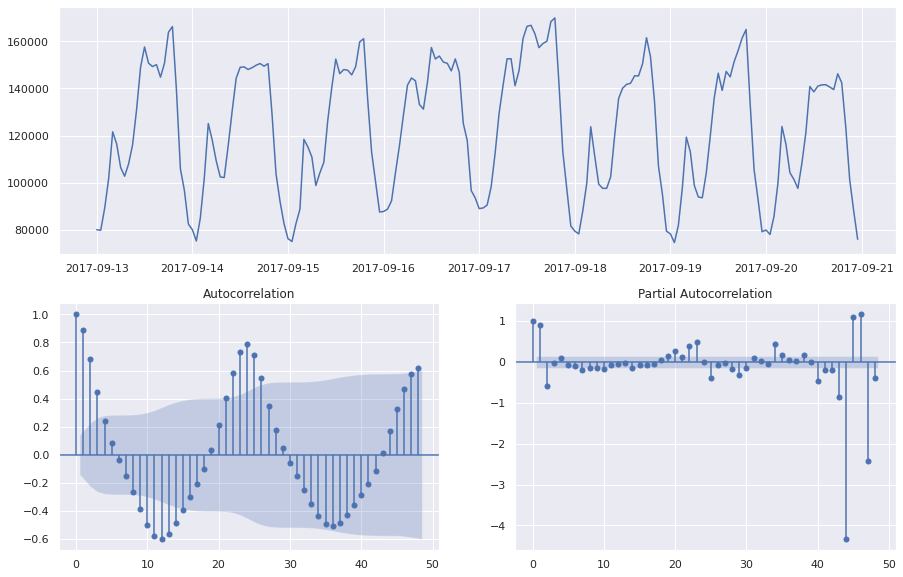

In [390]:
def tsa_plot(s):
    s = s.dropna()
    plt.figure(figsize=(15, 10))
    ax = plt.subplot2grid((2,2),(0, 0), colspan=2)
    ax.plot(s)
    ax = plt.subplot2grid((2,2),(1, 0))
    plot_acf(s, ax=ax, lags=48)
    ax = plt.subplot2grid((2,2),(1, 1))
    plot_pacf(s, ax=ax, lags=48)
    plt.show()
    
tsa_plot(ads.Ads)

<AxesSubplot:xlabel='Time'>

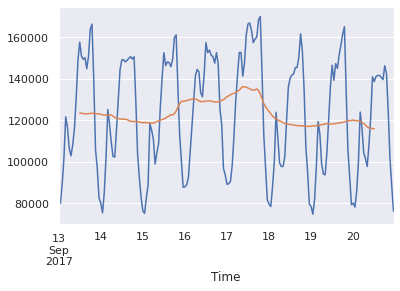

In [391]:
ads['sads'] = ads.Ads.rolling(24, center=True).mean()
ads.Ads.plot()
ads.sads.plot()

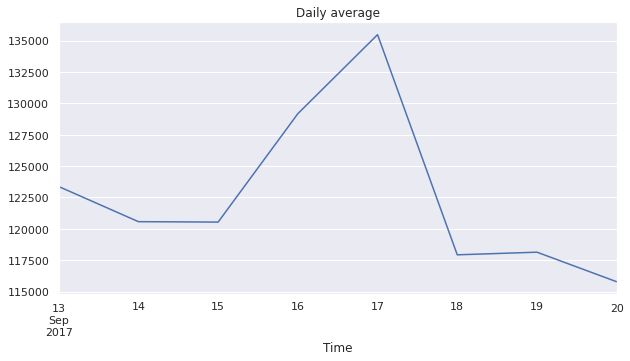

In [293]:
plt.figure(figsize=(10, 5))
plt.title("Daily average")
ads.Ads.resample('D').mean().plot()
plt.show()

## Test for stationarity

In [352]:
from statsmodels.tsa.stattools import adfuller
adfuller(ads.Ads)

(-6.844549866948455,
 1.7563546866784631e-09,
 9,
 182,
 {'1%': -3.4668001583460613,
  '5%': -2.8775552336674317,
  '10%': -2.5753075498128246},
 3700.9031934852173)

In [353]:
from statsmodels.tsa.stattools import kpss
kpss(ads.Ads, nlags='auto')

/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1885: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


(0.04560685792911657,
 0.1,
 8,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

These results indicate trend stationary

## Seasonly naive

In [294]:
ads.tail(1)

,Ads
Time,
2017-09-20 23:00:00,76050


In [295]:
# Forecast for Ads t+1
m = 24
h = 1
t = 23
lag = (t + h)%m - t
lag

-23

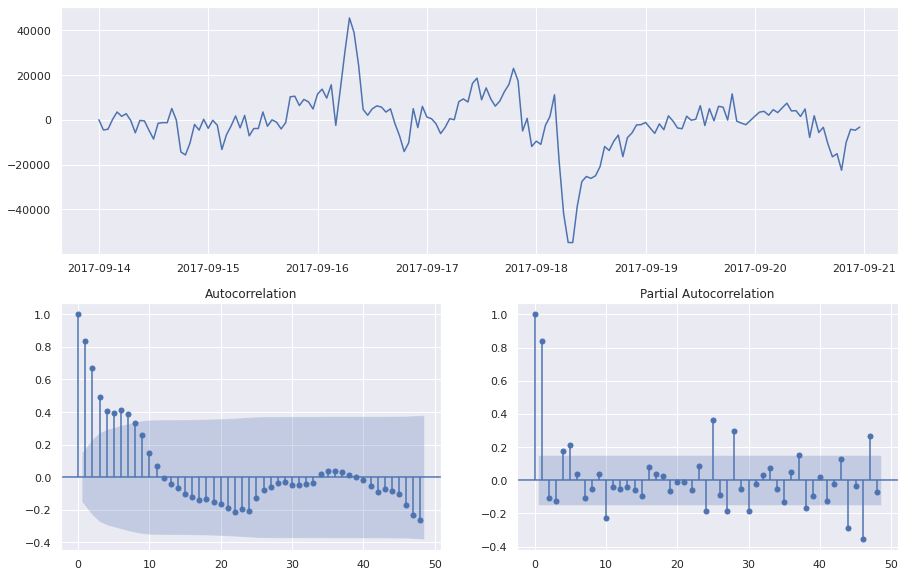

In [296]:
# In general
ads['fsn'] = ads.Ads.shift(24)
ads['rsn'] = ads.Ads - ads.fsn
tsa_plot(ads.rsn)

In [297]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ads.rsn.dropna(), lags=12, return_df=True)

,lb_stat,lb_pvalue
1,119.485854,8.197789e-28
2,196.338821,2.320420e-43
3,238.776217,1.750437e-51
4,267.424219,1.145448e-56
5,294.889891,1.256589e-61
6,324.538172,4.489785e-67
7,351.353154,6.324546e-72
8,370.722256,3.401241e-75
9,382.861465,6.195225e-77
10,386.688759,6.393652e-77


<AxesSubplot:>

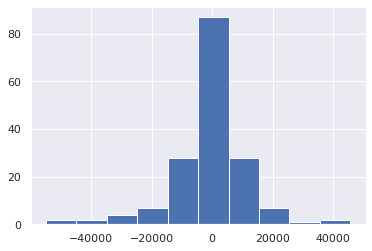

In [298]:
ads.rsn.hist()

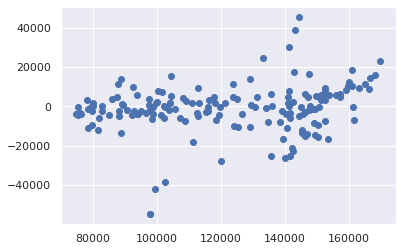

In [299]:
plt.scatter(ads.Ads, ads.rsn)

In [300]:
ads.Ads.corr(ads.rsn)

0.20172884450807518

In [301]:
nads = ads.dropna()
sn_mae = nads.rsn.abs().sum()/len(nads)
mase = nads.rsn.abs().mean()/sn_mae
mase

1.0

## Exponential smoothing

In [302]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

# Try full model
model = model = ETSModel(ads.Ads.astype('float64'), error="add", trend="add", seasonal="add", damped_trend=True, seasonal_periods=24, freq='H')
fit = model.fit(box_cox=True, maxiter=10000)
ads['fets'] = fit.fittedvalues
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                    Ads   No. Observations:                  192
Model:                      ETS(AAdA)   Log Likelihood               -2013.255
Date:                Sat, 30 Jan 2021   AIC                           4088.511
Time:                        16:37:11   BIC                           4189.493
Sample:                    09-13-2017   HQIC                          4129.409
                         - 09-20-2017   Scale                     75040135.227
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9752      0.256      3.807      0.000       0.473       1.477
smoothing_trend         0.6821      0.343      1.991      0.046       0.011       1.354
smoothing_seasonal      0.0248      0.028      0.895      0.371      -0.029       0.079
damping_trend           0.8000      0.123      6.516      0.000       0.559       1.041
initial_level        1.232e+05   2.67e+04      4.612      0.000    7.09e+04    1.76e+05
initial_trend          -6.5712   1.81e+04     -0.000      1.000   -3.56e+04    3.55e+04
initial_seasonal.0  -3402.2659   8671.839     -0.392      0.695   -2.04e+04    1.36e+04
initial_seasonal.1  -4701.4840   7636.090     -0.616      0.538   -1.97e+04    1.03e+04
initial_seasonal.2    646.4848   6042.229      0.107      0.915   -1.12e+04    1.25e+04
initial_seasonal.3   1.128e+04   5826.646      1.935      0.053    -143.166    2.27e+04
initial_seasonal.4   3.078e+04   6910.745      4.453      0.000    1.72e+04    4.43e+04
initial_seasonal.5   3.554e+04        nan        nan        nan         nan         nan
initial_seasonal.6    3.83e+04   1640.240     23.351      0.000    3.51e+04    4.15e+04
initial_seasonal.7    3.71e+04   4138.135      8.966      0.000     2.9e+04    4.52e+04
initial_seasonal.8   3.805e+04   5732.554      6.637      0.000    2.68e+04    4.93e+04
initial_seasonal.9   3.715e+04   7579.436      4.901      0.000    2.23e+04     5.2e+04
initial_seasonal.10  4.638e+04   9604.751      4.829      0.000    2.76e+04    6.52e+04
initial_seasonal.11  5.948e+04   9150.380      6.500      0.000    4.15e+04    7.74e+04
initial_seasonal.12  6.948e+04   9396.550      7.394      0.000    5.11e+04    8.79e+04
initial_seasonal.13  6.494e+04   9756.053      6.656      0.000    4.58e+04    8.41e+04
initial_seasonal.14    6.5e+04   8688.621      7.481      0.000     4.8e+04     8.2e+04
initial_seasonal.15   6.47e+04   7132.784      9.070      0.000    5.07e+04    7.87e+04
initial_seasonal.16  6.305e+04   2943.729     21.420      0.000    5.73e+04    6.88e+04
initial_seasonal.17  6.478e+04   1349.749     47.992      0.000    6.21e+04    6.74e+04
initial_seasonal.18  7.141e+04   3983.470     17.928      0.000    6.36e+04    7.92e+04
initial_seasonal.19  7.077e+04   6610.350     10.706      0.000    5.78e+04    8.37e+04
initial_seasonal.20  4.645e+04   6037.356      7.694      0.000    3.46e+04    5.83e+04
initial_seasonal.21  2.388e+04   7440.341      3.210      0.001    9300.194    3.85e+04
initial_seasonal.22  9985.2593   7882.557      1.267      0.205   -5464.269    2.54e+04
initial_seasonal.23          0   8601.802          0      1.000   -1.69e+04    1.69e+04
===================================================================================
Ljung-Box (Q):                      147.86   Jarque-Bera (JB):                57.47
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.60   Skew:                            -0.48
P

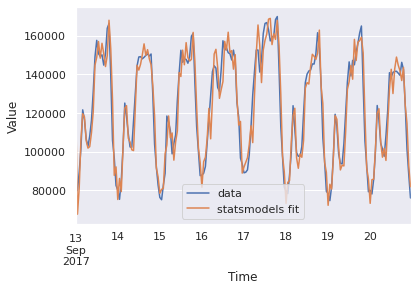

In [303]:
ads.Ads.plot(label='data')
fit.fittedvalues.plot(label='statsmodels fit')
plt.ylabel("Value")
plt.legend();

In [310]:
# Try without trend
model = ETSModel(ads.Ads.astype('float64'), error="add", trend=None, seasonal="add", seasonal_periods=24, freq='H')
fit = model.fit(maxiter=10000)
ads['fets'] = fit.fittedvalues
ads['rets'] = ads.Ads - ads.fets
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:                    Ads   No. Observations:                  192
Model:                       ETS(ANA)   Log Likelihood               -2047.636
Date:                Sat, 30 Jan 2021   AIC                           4151.272
Time:                        16:38:14   BIC                           4242.482
Sample:                    09-13-2017   HQIC                          4188.212
                         - 09-20-2017   Scale                    107356255.629
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.037     27.001      0.000       0.927       1.072
smoothing_seasonal   9.999e-05        nan        nan        nan         nan         nan
initial_level        1.232e+05   1.17e+04     10.529      0.000       1e+05    1.46e+05
initial_seasonal.0  -3402.2954   4937.247     -0.689      0.491   -1.31e+04    6274.531
initial_seasonal.1  -4701.4671   4647.506     -1.012      0.312   -1.38e+04    4407.477
initial_seasonal.2    646.4640   2943.472      0.220      0.826   -5122.635    6415.563
initial_seasonal.3   1.128e+04        nan        nan        nan         nan         nan
initial_seasonal.4   3.078e+04        nan        nan        nan         nan         nan
initial_seasonal.5   3.554e+04        nan        nan        nan         nan         nan
initial_seasonal.6    3.83e+04        nan        nan        nan         nan         nan
initial_seasonal.7    3.71e+04   2968.152     12.501      0.000    3.13e+04    4.29e+04
initial_seasonal.8   3.805e+04   2872.990     13.243      0.000    3.24e+04    4.37e+04
initial_seasonal.9   3.715e+04   3623.388     10.252      0.000       3e+04    4.42e+04
initial_seasonal.10  4.638e+04   4457.856     10.405      0.000    3.76e+04    5.51e+04
initial_seasonal.11  5.948e+04   5191.912     11.456      0.000    4.93e+04    6.97e+04
initial_seasonal.12  6.948e+04   5108.515     13.600      0.000    5.95e+04    7.95e+04
initial_seasonal.13  6.494e+04   3935.239     16.502      0.000    5.72e+04    7.27e+04
initial_seasonal.14    6.5e+04   2010.947     32.321      0.000    6.11e+04    6.89e+04
initial_seasonal.15   6.47e+04        nan        nan        nan         nan         nan
initial_seasonal.16  6.305e+04        nan        nan        nan         nan         nan
initial_seasonal.17  6.478e+04        nan        nan        nan         nan         nan
initial_seasonal.18  7.141e+04        nan        nan        nan         nan         nan
initial_seasonal.19  7.077e+04        nan        nan        nan         nan         nan
initial_seasonal.20  4.645e+04   1957.693     23.729      0.000    4.26e+04    5.03e+04
initial_seasonal.21  2.388e+04   3418.073      6.987      0.000    1.72e+04    3.06e+04
initial_seasonal.22  9985.2447   4578.944      2.181      0.029    1010.679     1.9e+04
initial_seasonal.23          0   4989.539          0      1.000   -9779.316    9779.316
===================================================================================
Ljung-Box (Q):                      878.48   Jarque-Bera (JB):                 2.07
Prob(Q):                              0.00   Prob(JB):                         0.36
Heteroskedasticity (H):               0.80   Skew:                            -0.13
Prob(H) (two-sided):                  0.36   Kurtosis:                         3.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] C

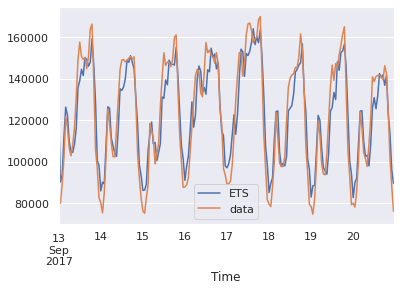

In [311]:
ads.fets.plot(label='ETS')
ads.Ads.plot(label="data")
plt.legend();

<AxesSubplot:>

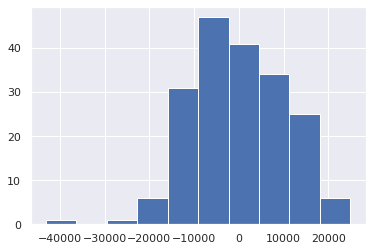

In [312]:
ads.rets.hist()

In [313]:
from statsmodels.stats.stattools import jarque_bera
jarque_bera(ads.rets)

(2.06995009410514,
 0.3552352449807521,
 -0.12544052268014158,
 3.4424957207048155)

In [314]:
nads = ads.dropna()
sn_mae = nads.rsn.abs().sum()/len(nads)
mase = nads.rets.abs().mean()/sn_mae
mase

1.0083550511853865

## ARIMA

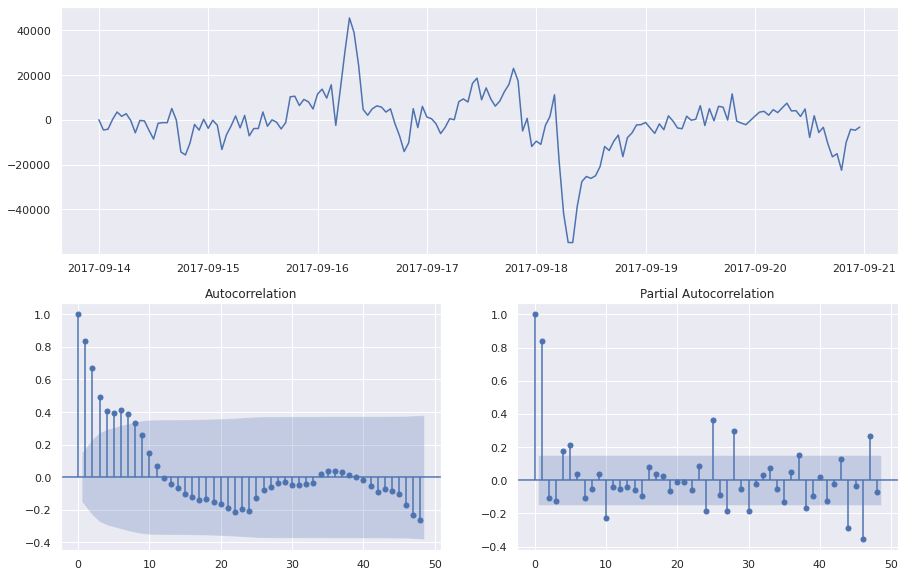

In [315]:
ads['d24'] = ads.Ads - ads.Ads.shift(24)
tsa_plot(ads.d24)

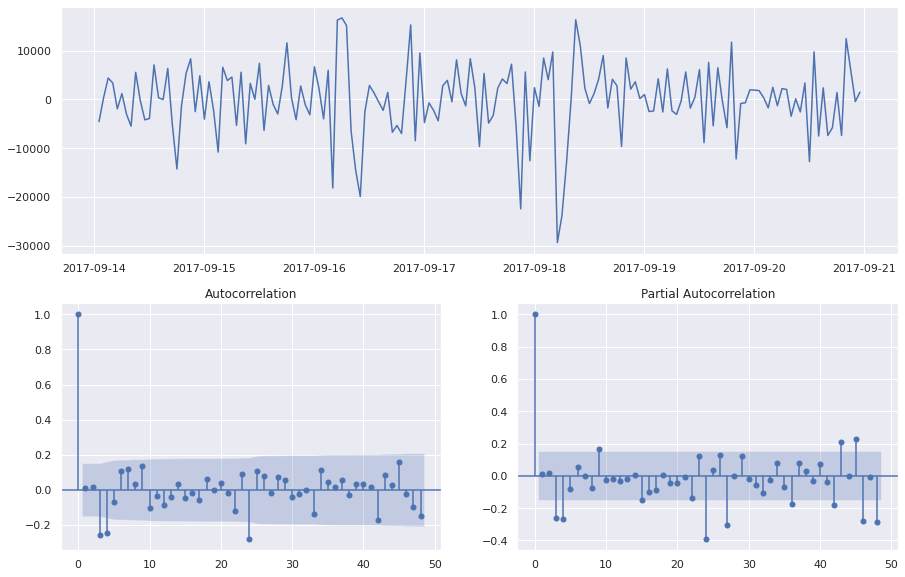

In [316]:
ads['d24d1'] = ads.d24 - ads.d24.shift(1)
tsa_plot(ads.d24d1)

In [317]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ads.d24d1.dropna(), lags=12, return_df=True)

,lb_stat,lb_pvalue
1,0.018827,0.890863
2,0.070638,0.965298
3,11.435560,0.009589
4,22.001532,0.000200
5,22.871193,0.000357
6,24.899352,0.000356
7,27.351182,0.000288
8,27.546259,0.000569
9,30.846742,0.000314
10,32.826236,0.000291


In [393]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(ads.Ads, order=(3, 1, 3), seasonal_order=(2, 1, 1, 24), freq='H')
fit = model.fit()
ads['farima'] = fit.fittedvalues
ads['rarima'] = ads.Ads - ads.farima

/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [401]:
y_hat = fit.forecast(1)
y_hat.values.item()

75765.66228756998

In [319]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                  Ads   No. Observations:                  192
Model:             SARIMAX(3, 1, 3)x(2, 1, [1], 24)   Log Likelihood               -1694.890
Date:                              Sat, 30 Jan 2021   AIC                           3409.779
Time:                                      16:39:08   BIC                           3440.959
Sample:                                  09-13-2017   HQIC                          3422.435
                                       - 09-20-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6184      0.573      1.079      0.280      -0.504       1.741
ar.L2         -0.3250      0.665     -0.489      0.625      -1.628       0.978
ar.L3         -0.2009      0.536     -0.375      0.708      -1.251       0.849
ma.L1         -0.5448      0.587     -0.928      0.354      -1.696       0.606
ma.L2          0.3604      0.611      0.590      0.555      -0.837       1.558
ma.L3         -0.0034      0.496     -0.007      0.995      -0.975       0.968
ar.S.L24       0.3038      0.153      1.987      0.047       0.004       0.604
ar.S.L48      -0.0790      0.065     -1.223      0.221      -0.205       0.048
ma.S.L24      -0.7178      0.186     -3.851      0.000      -1.083      -0.353
sigma2      4.711e+07   1.69e-08   2.78e+15      0.000    4.71e+07    4.71e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.62   Jarque-Bera (JB):                 4.84
Prob(Q):                              0.43   Prob(JB):                         0.09
Heteroskedasticity (H):               0.59   Skew:                            -0.20
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.04e+32. Standard errors may be unstable.
"""

## Evaluate with rolling forecast origin

In [403]:
all_data = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'], names=['Time', 'Ads'])
val_data = all_data.drop(all_data.tail(40).index)
train_data = val_data.drop(val_data.tail(40).index)

In [419]:
from sklearn.model_selection import TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=40, test_size=1)
errors = []
for train_fold, val_fold in tss.split(val_data):
    t = val_data.iloc[train_fold, :]
    v = val_data.iloc[val_fold, :]
    model = SARIMAX(t.Ads, order=(3, 1, 3), seasonal_order=(2, 1, 1, 24), freq='H')
    fit = model.fit()
    # Calculate val error
    y_hat = fit.forecast(1)
    error = v.Ads.values.item() - y_hat
    errors.append(error)
    

/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'
/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/

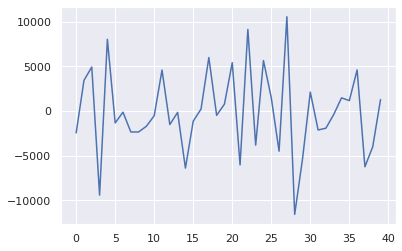

In [420]:
plt.plot(errors)

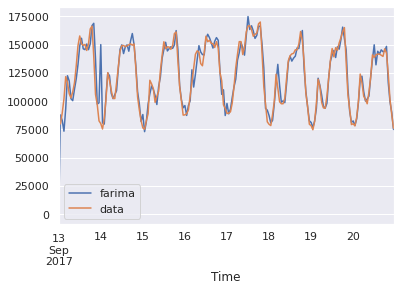

In [320]:
ads.farima.plot(label='farima')
ads.Ads.plot(label='data')
plt.legend();


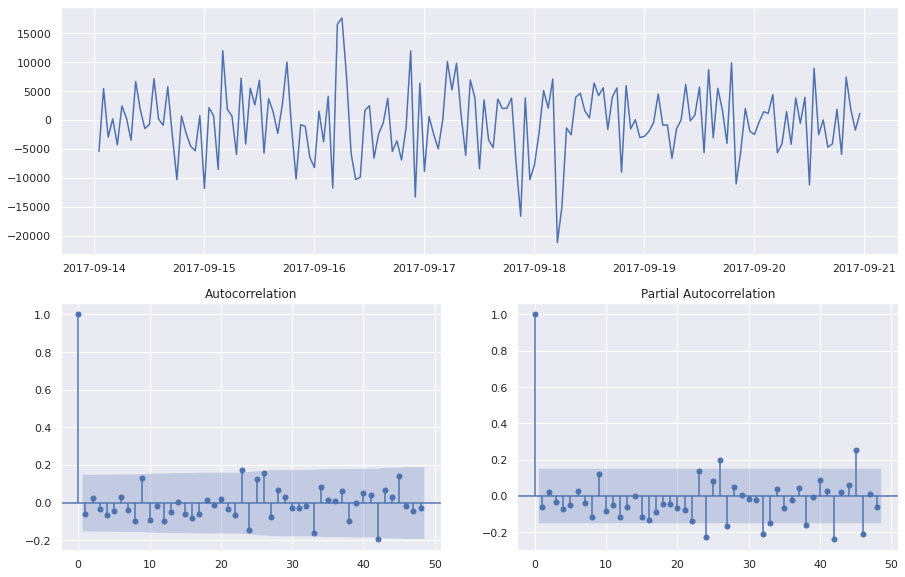

In [321]:
tsa_plot(ads.rarima[25:])

In [322]:
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ads.rarima[25:].dropna(), lags=24, return_df=True)

,lb_stat,lb_pvalue
1,0.640401,0.423566
2,0.729415,0.694400
3,0.935247,0.816915
4,1.703007,0.790171
5,2.033491,0.844492
6,2.168539,0.903564
7,2.417943,0.933148
8,4.056776,0.851965
9,7.003298,0.636776
10,8.463338,0.583675


In [323]:
nads = ads.dropna()
sn_mae = nads.rsn.abs().sum()/len(nads)
mase = nads.rarima.abs().mean()/sn_mae
mase

0.5703990672420806

## Time series linear model

In [356]:
def fourier_feature(t, m, n):
    features = np.zeros((t, 2*n))
    t = np.arange(0, t)
    for k in range(0, n):
        features[:,2*k] = np.sin(2*np.pi*(k+1)*t/m)
        features[:,2*k+1] = np.cos(2*np.pi*(k+1)*t/m)
    
    df = pd.DataFrame(features, columns=[f"f{m}{i+1}" for i in range(0,2*n)])
    df['t'] = t
    return df

t=len(ads)
daily_df = fourier_feature(t,24,8)
daily_df.index = ads.index
weekly_df = fourier_feature(t,168,8)
weekly_df.index = ads.index
tlm_ads = pd.concat([ads, daily_df, weekly_df], axis=1)

In [357]:
tlm_ads.columns

Index(['Ads', 'fsn', 'rsn', 'fets', 'rets', 'd24', 'd24d1', 'farima', 'rarima',
       'ftlm', 'rtlm', 'f241', 'f242', 'f243', 'f244', 'f245', 'f246', 'f247',
       'f248', 'f249', 'f2410', 'f2411', 'f2412', 'f2413', 'f2414', 'f2415',
       'f2416', 't', 'f1681', 'f1682', 'f1683', 'f1684', 'f1685', 'f1686',
       'f1687', 'f1688', 'f1689', 'f16810', 'f16811', 'f16812', 'f16813',
       'f16814', 'f16815', 'f16816', 't'],
      dtype='object')

In [363]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(tlm_ads.Ads, exog=tlm_ads[['t'] + daily_df.columns.tolist() + weekly_df.columns.tolist()].values, order=(2,0,2), freq='H')
fit = model.fit()
ads['ftlm'] = fit.fittedvalues
ads['rtlm'] = ads.Ads - ads.ftlm

/home/sanne/.virtualenvs/ts/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  warnings.warn('No frequency information was'


In [364]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    Ads   No. Observations:                  192
Model:                 ARIMA(2, 0, 2)   Log Likelihood               -1867.924
Date:                Sat, 30 Jan 2021   AIC                           3823.847
Time:                        16:55:39   BIC                           3967.177
Sample:                    09-13-2017   HQIC                          3881.897
                         - 09-20-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.276e+05    543.984    234.520      0.000    1.27e+05    1.29e+05
x1            -7.7563      0.967     -8.019      0.000      -9.652      -5.861
x2            -7.7563      0.967     -8.020      0.000      -9.652      -5.861
x3         -8705.4294    278.294    -31.281      0.000   -9250.876   -8159.982
x4         -1.341e+04    296.197    -45.270      0.000    -1.4e+04   -1.28e+04
x5          4211.8879   1617.684      2.604      0.009    1041.286    7382.490
x6         -1.166e+04   1488.497     -7.831      0.000   -1.46e+04   -8739.232
x7          2705.5683   1525.742      1.773      0.076    -284.831    5695.968
x8          -1.03e+04   1321.721     -7.796      0.000   -1.29e+04   -7713.176
x9          -799.3335    859.678     -0.930      0.352   -2484.272     885.605
x10         3377.8754    905.033      3.732      0.000    1604.043    5151.708
x11        -1256.8223    680.399     -1.847      0.065   -2590.380      76.736
x12         2340.9132    611.932      3.825      0.000    1141.549    3540.277
x13        -1813.9790    508.086     -3.570      0.000   -2809.809    -818.149
x14         1159.7059    526.932      2.201      0.028     126.939    2192.473
x15         1407.4249    427.786      3.290      0.001     568.980    2245.869
x16         -934.5431    486.266     -1.922      0.055   -1887.606      18.520
x17          786.9533    459.459      1.713      0.087    -113.570    1687.477
x18         -646.5519    377.212     -1.714      0.087   -1385.874      92.770
x19           -7.7563      0.967     -8.020      0.000      -9.652      -5.861
x20           -7.7563      0.967     -8.020      0.000      -9.652      -5.861
x21        -3973.2765    525.778     -7.557      0.000   -5003.782   -2942.771
x22        -5192.9805    226.085    -22.969      0.000   -5636.099   -4749.862
x23         3352.3696    329.610     10.171      0.000    2706.346    3998.394
x24         3398.1985    270.910     12.544      0.000    2867.224    3929.173
x25         -855.9278    272.490     -3.141      0.002   -1389.998    -321.858
x26         1653.3179    313.258      5.278      0.000    1039.344    2267.292
x27        -2869.0967    299.180     -9.590      0.000   -3455.479   -2282.715
x28        -1726.8950    371.988     -4.642      0.000   -2455.979    -997.811
x29         4100.5024    408.322     10.042      0.000    3300.207    4900.798
x30         1667.4589    418.187      3.987      0.000     847.828    2487.090
x31        -3328.6317    471.778     -7.056      0.000   -4253.299   -2403.965
x32         1990.9580    508.842      3.913      0.000     993.645    2988.271
x33        -8705.4294    278.294    -31.281      0.000   -9250.876   -8159.982
x34        -1.341e+04    296.197    -45.270      0.000    -1.4e+04   -1.28e+04
x35        -2933.7110    623.679     -4.704      0.000   -4156.099   -1711.323
x36          860.1442    712.627      1.207      0.227    -536.580    2256.868
x37           -7.7563      0.967     -8.020      0.000      -9.652      -5.861
x3

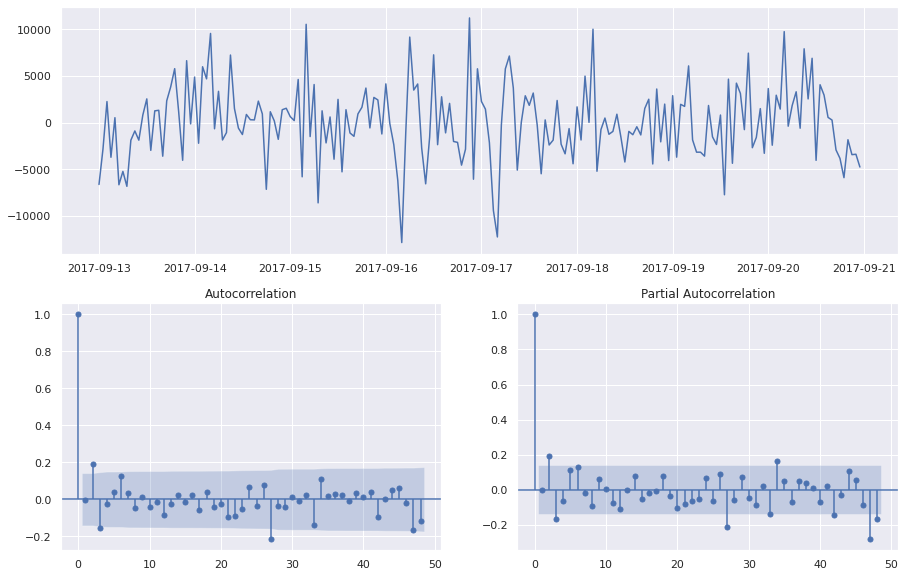

In [365]:
tsa_plot(ads.rtlm)

In [366]:
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
acorr_breusch_godfrey(fit, nlags=24)

(48.033993130954805,
 0.002499781693973496,
 1.735598930302553,
 0.02622432939177958)

In [367]:
nads = ads.dropna()
sn_mae = nads.rsn.abs().sum()/len(nads)
mase = nads.rtlm.abs().mean()/sn_mae
mase

0.3849897017942321

## Missing values

In [373]:
time_index = pd.date_range("1/01/2021", periods=6, freq="W")
df = pd.DataFrame(index=time_index)
df["Sales"] = [5.0,4.0,np.nan,np.nan,1.0,np.nan]
df.head()

,Sales
2021-01-03,5.0
2021-01-10,4.0
2021-01-17,NaN
2021-01-24,NaN
2021-01-31,1.0


In [376]:
df[df.isna()]

,Sales
2021-01-03,NaN
2021-01-10,NaN
2021-01-17,NaN
2021-01-24,NaN
2021-01-31,NaN
2021-02-07,NaN


In [382]:
df['Sales'] = df['Sales'].interpolate()

In [384]:
df['Sales'][df['Sales'].isna()]

Series([], Freq: W-SUN, Name: Sales, dtype: float64)

In [386]:
df['Sales'].isna()

2021-01-03    False
2021-01-10    False
2021-01-17    False
2021-01-24    False
2021-01-31    False
2021-02-07    False
Freq: W-SUN, Name: Sales, dtype: bool